In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from thesis.io import fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate
from thesis.glitch import estimate_asy

from glitchpy.supportGlitch import smoothComponent, totalGlitchSignal, glitchSignal, averageAmplitudes
from glitchpy.supportGlitch import fit

In [3]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
data = fgong.load_fgong(filename)
data

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [4]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


In [71]:
name = "worst"
df = pd.read_csv(f"data/glitch-inputs-{name}.csv")
df.head()

,n,l,nu_true,nu,nu_err
0,18,0,2574.262983,2577.249488,1.0
1,19,0,2706.595870,2706.442841,1.0
2,20,0,2839.476225,2838.996750,1.0
3,21,0,2972.726600,2971.452099,1.0
4,22,0,3105.759219,3107.406018,1.0


In [72]:
n, nu, nu_err = df.n.to_numpy(), df.nu.to_numpy(), df.nu_err.to_numpy()

delta_nu, epsilon = estimate_asy(n, nu, nu_err=nu_err)

print(f"{delta_nu.mean:.2f} ± {delta_nu.variance**0.5:.2f}")

132.83 ± 0.47


In [73]:
freq = df[["l", "n", "nu", "nu_err"]].to_numpy()

<ErrorbarContainer object of 3 artists>

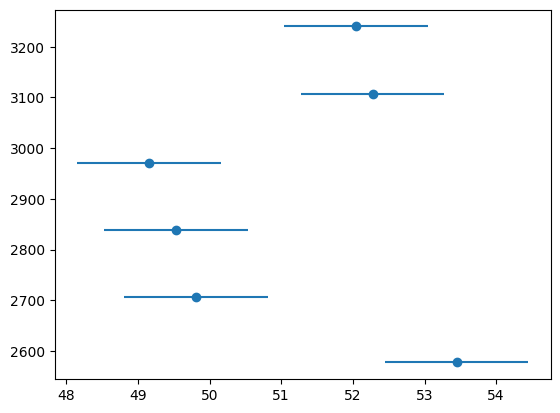

In [74]:
fig, ax = plt.subplots()

ax.errorbar(freq[:, 2]%delta_nu.mean, freq[:, 2], xerr=freq[:, 3], fmt="o")

In [75]:
num_of_l = np.unique(freq[:, 0]).shape[0]
num_of_n = np.zeros(num_of_l, dtype=int)
for i in range(num_of_l):
    num_of_n[i] = freq[freq[:, 0] == i].shape[0]
    
tol_grad = 1e-3
if name == "better":
    tol_grad = 1e-2
elif name == "best":
    tol_grad = 1e-1

In [76]:
n_rln = 1000
reg = 7.0
n_guess = 200

param, chi2, reg, ier, ratio = fit(
    freq, num_of_n, delta_nu.mean, n_rln=n_rln, tol_grad=tol_grad, regu_param=reg, n_guess=n_guess,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:29<00:00, 11.20it/s]


In [77]:
param_names = [
    "b0",
    "b1",
    "b2",
    "b3",
    "b4",
    "a_cz",
    "tau_cz",
    "phi_cz",
    "a_he",
    "delta_he",
    "tau_he",
    "phi_he",
]

In [78]:
samples = np.concatenate((param, chi2[:, None], reg[:, None]), axis=1)
samples_names = param_names + ["chi2", "reg"]

In [79]:
df = pd.DataFrame(samples, columns=samples_names)
df.head()

,b0,b1,b2,b3,b4,a_cz,tau_cz,phi_cz,a_he,delta_he,tau_he,phi_he,chi2,reg
0,-351.240399,188.437120,-1.425747,0.000000e+00,0.000000e+00,9.367640e+06,1793.025239,0.766787,0.003617,6.944905,500.431512,5.865961,0.0,0.0
1,-773.457660,227.443744,-2.314141,-9.845256e-166,1.269809e-167,1.801579e+07,1377.778732,2.964485,0.111661,70.382748,506.067093,5.127843,0.0,0.0
2,242.481390,126.189523,0.180260,-2.153859e-174,2.558757e-176,1.367696e+07,2086.330188,2.075964,2218.238343,160.103357,683.736258,3.439358,0.0,0.0
3,-115.979201,162.048371,-0.705903,7.563403e-165,-8.850115e-167,1.000726e+05,2390.267981,3.853993,0.017068,59.681740,636.638884,0.518694,0.0,0.0
4,269.338076,123.238802,0.259577,3.739937e-173,-5.843651e-175,9.958885e+06,2155.584730,5.760470,144.622873,144.371724,640.581977,5.556757,0.0,0.0


In [80]:
# filepath = os.path.expanduser(f"~/OneDrive/Data/alexlyttle/thesis/v19-glitch-samples-{name}.csv")
filepath = f"data/v19-glitch-results-{name}.csv"
df.to_csv(filepath)

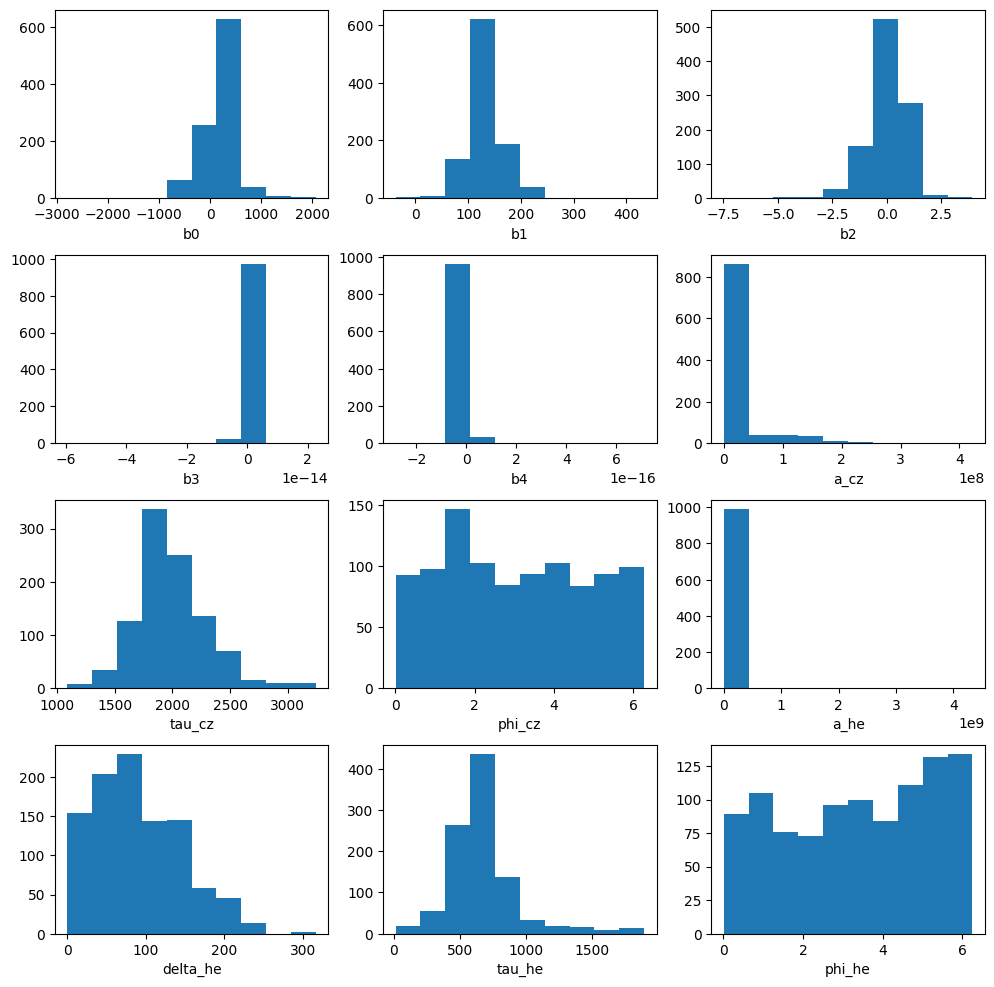

In [81]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), gridspec_kw={"hspace": 0.3})

for i, ax in enumerate(axes.ravel()):
    ax.hist(param[:-1, i])
    ax.set_xlabel(param_names[i])

In [82]:
nu_max_sol = 3090.0
g_sol = 10**4.44
teff_sol = 5777.0

g = data.G * data.M / data.R**2
nu_max = nu_max_sol * g / g_sol * (data.Teff/teff_sol)**-0.5

In [83]:
def helium_at_nu(param, nu):
    return param[:, -4] * nu * np.exp(- 8e-12 * np.pi**2 * param[:, -3]**2 * nu**2)

In [84]:
amp_numax = helium_at_nu(param, nu_max)

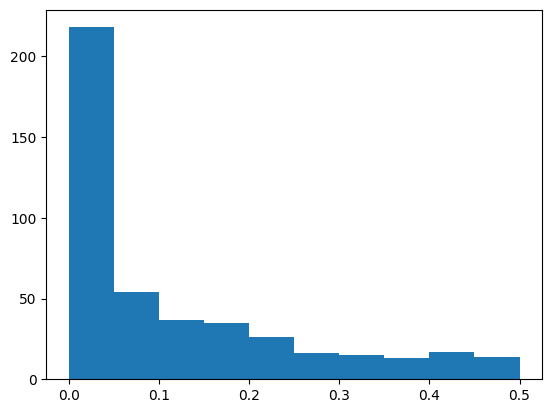

In [85]:
plt.hist(amp_numax, range=(0., 0.5));

In [86]:
def _oscillation(nu, tau, phi):
    return np.sin(4 * np.pi * tau * nu + phi)

def poly(p, x):
    powers = np.arange(p.shape[-1])
    return np.sum(p*x[..., None]**powers, axis=-1)

def smooth_component(param, n, npoly_params=5):
    return np.apply_along_axis(
        poly, 
        -1,
        param[..., :npoly_params], 
        n,
    )

def helium_amp(param, nu):
    return param[..., -4, None] * nu * np.exp(- 8e-12 * np.pi**2 * param[..., -3, None]**2 * nu**2)

def helium_glitch(param, nu):
    return helium_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -2, None], param[..., -1, None])

def bcz_amp(param, nu):
    return param[..., -7, None] / nu**2

def bcz_glitch(param, nu):
    return bcz_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -6, None], param[..., -5, None])

def glitch(param, nu):
    return helium_glitch(param, nu) + bcz_glitch(param, nu)

In [87]:
from corner import corner

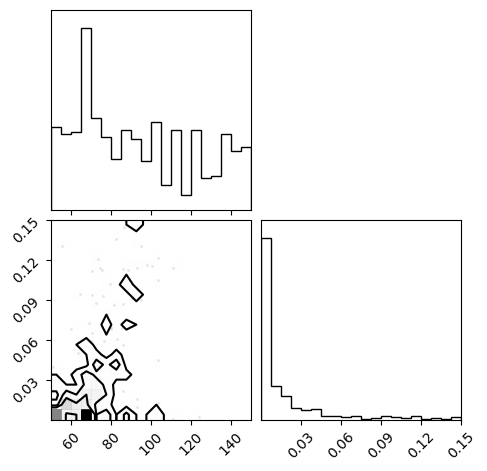

In [88]:
corner(param[:, [-3, -4]], range=[(50, 150), (0, 0.15)]);

In [89]:
nu_sm = smooth_component(param, freq[:, 1])
dnu = glitch(param, nu_sm)
nu = nu_sm + dnu

In [90]:
thin = 20

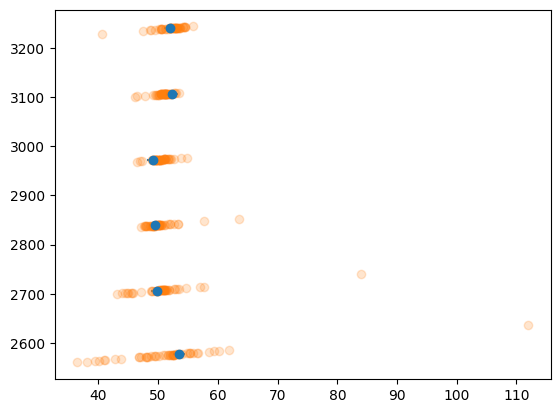

In [91]:
fig, ax = plt.subplots()

ax.errorbar(freq[:, 2]%delta_nu.mean, freq[:, 2], xerr=freq[:, 3], fmt="o")
ax.plot(nu_sm[::thin]%delta_nu.mean, nu_sm[::thin], "o", color="C1", alpha=0.2);
# ax.plot(nu%delta_nu, nu, "o", markerfacecolor="none")
# ax.set_xlim(50, 60)

In [92]:
num_points = 501
nu_pred = np.linspace(freq[:, 2].min(), freq[:, 2].max(), num_points)
dnu_pred = glitch(param, nu_pred)

In [93]:
dnu_he_pred = helium_glitch(param[-1, :], nu_pred)
dnu_cz_pred = bcz_glitch(param[-1, :], nu_pred)

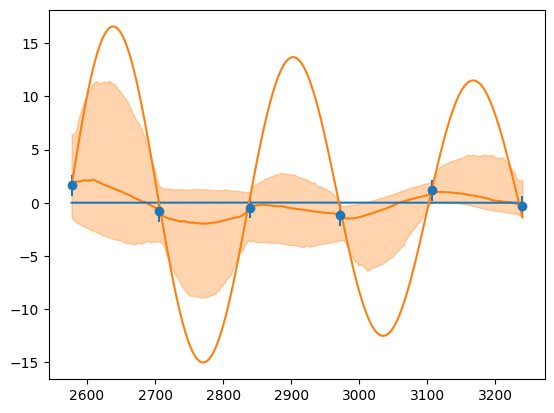

In [97]:
fig, ax = plt.subplots()
ax.errorbar(freq[:, 2], freq[:, 2] - np.median(nu_sm, axis=0), yerr=freq[:, 3], fmt="o", color="C0", label="data")
# ax.plot(nu_pred[::thin].T, dnu_pred[::thin].T, alpha=0.2, color="C0")


dnu_med = np.median(dnu_pred, axis=0)
dnu_lower, dnu_upper = np.quantile(dnu_pred, [.16, .84], axis=0)

ax.plot(nu_pred, dnu_med, color="C1")
ax.fill_between(nu_pred, dnu_lower, dnu_upper, color="C1", alpha=0.33)
# ax.plot(nu_pred, dnu_he_pred, label="He")
# ax.plot(nu_pred, dnu_cz_pred, label="CZ")
# ax.set_ylim(-5, 5)
# ax.legend();

Difference between prediciton and truth

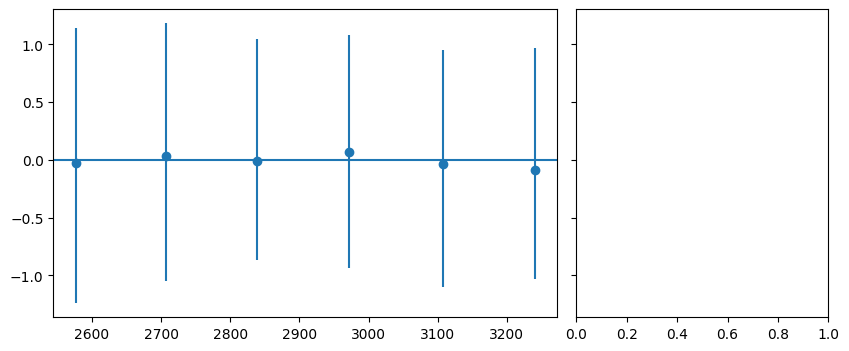

In [95]:
res = nu - freq[:, 2]
res_med = np.median(res, axis=0)
res_unc = np.abs(res_med - np.quantile(res, [.16, .84], axis=0))

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True,
                         gridspec_kw={"wspace": 0.05, "width_ratios": [2, 1]})

ax = axes[0]
ax.errorbar(freq[:, 2], res_med, yerr=res_unc, fmt="o")
# for l in range(num_of_l):
#     mask = freq[:, 0] == l
#     ax.plot(nu[mask], res[mask], "o", label=l)
    

ax.axhline()
# ax.legend()

ax = axes[1]
# ax.hist(res.flatten(), orientation="horizontal", color="k", histtype="step");

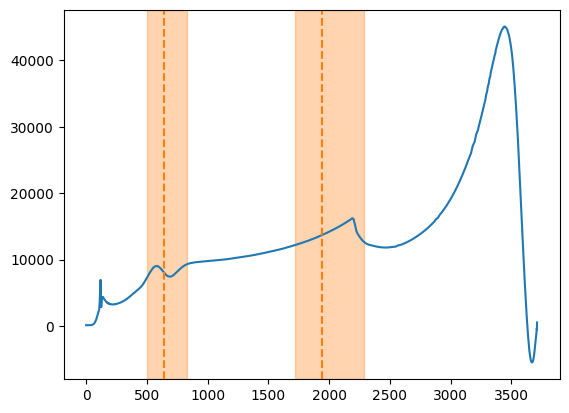

In [96]:
plt.plot(data.tau, differentiate(data.cs, data.tau))

plt.axvline(np.median(param[:, -2]), c="C1", ls="--")
plt.axvline(np.median(param[:, -6]), c="C1", ls="--")

plt.axvspan(*np.quantile(param[:, -2], [.16, .84]), color="C1", alpha=0.33)
plt.axvspan(*np.quantile(param[:, -6], [.16, .84]), color="C1", alpha=0.33)